
# Introduction
Seismology is the study of earthquakes and seismic waves that move through and around the earth[1].

# What we want to do
Seismic wave includes metadata and physical waveform files. Metadata includes crucial information about seismic waves like event, origin, station, etc. Waveform files includes the physical waveforms. The Waveform file is binary file, with artificial noises mixed within it, impossible to read and analyze. We learnt about how seismic travel through Earth in the midterm project. For the final one, we wanted to learn how seismic wave travel on the surface of Earth, which was called Ground Motion Visualization is Seismoloy. 

Our goal is to build an animation for GMV on web page. So we need to assemble our data and play it frame by frame. To do that, we selected an event that had more stations recording it, so we can have a clearer picture of how the seismic wave travels.


# Relevant Work
There is a project called USArray GMV[2], which is the visualizations of real data showing how seismic waves sweep across the USArray network of seismic stations and Watch how seismic waves from earthquakes in the US and around the world cause the ground to move at each seismometer.

# Tools and visualization techniques
We use obspy[3], a Python Toolbox for seismology/seismological observatories. It provides parsers for common file formats, clients to access data centers and seismological signal processing routines which allow the manipulation of seismological time series. We also use matplotlib and numpy.

For visualization methods, we use heat map and javascript to animate GMV.

The following functions are all from mid-term project, filtering[4] and decimation[5] are very important in seismic wave processing. 

In [372]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload  
%autoreload 2   # Reload all modules (except those excluded by %aimport) every time
import sys


"""
"""
def usage():
    print 'python reader.py [OPTIONS]\n\
    \t -h --help\t\t\tPrint this help screen\n\
    \t -i --mongodb_host\t\tMongoDB server host (default: localhost)\n\
    \t -p --mongodb_port\t\tMongoDB server port (default: 27017)\n '

def createMongoClient(mongodb_host, mongodb_port):
    from pymongo import MongoClient
    try:
        mongoclient = MongoClient('mongodb://' + mongodb_host + ':' + mongodb_port)
        mongodb = mongoclient['test']
        return mongodb
    except pymongo.errors.ConnnectionFailure, e:
        print('Could not connect to MongoDB: %s' % e)
        sys.exit(1)
        
def filtering(tr):
    tr_filt = tr.copy()
    tr_filt.filter('lowpass', freq=1.0, corners=2, zerophase=True)
    t = np.arange(0, tr.stats.npts / tr.stats.sampling_rate, tr.stats.delta)
    plt.subplot(211)
    plt.plot(t, tr.data, 'k', label='Raw')
    plt.ylabel('Raw Data')
    plt.xlim(0, 50)
    plt.subplot(212)
    plt.plot(t, tr_filt.data, 'k', label='Lowpassed')
    plt.ylabel('Lowpassed Data')
    plt.xlabel('Time [s]')
    plt.xlim(0, 50)
    plt.suptitle(tr.stats.starttime)
    plt.show()

def downSampling(tr):
    tr_new = tr.copy()
    tr_new.decimate(factor=4, strict_length=False)
    tr_filt = tr.copy()
    tr_filt.filter('lowpass', freq=0.4 * tr.stats.sampling_rate / 4.0)

    # Now let's plot the raw and filtered data...
    t = np.arange(0, tr.stats.npts / tr.stats.sampling_rate, tr.stats.delta)
    t_new = np.arange(0, tr_new.stats.npts / tr_new.stats.sampling_rate,
                  tr_new.stats.delta)

    plt.plot(t, tr.data, 'k', label='Raw', alpha=0.3)
    plt.plot(t, tr_filt.data, 'b', label='Lowpassed', alpha=0.7)
    plt.plot(t_new, tr_new.data, 'r', label='Lowpassed/Downsampled', alpha=0.7)
    plt.xlabel('Time [s]')
    plt.xlim(100, 140)
    plt.suptitle(tr.stats.starttime)
    plt.legend()
    plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Our data including the metadata and waveform are stored in MongoDB, so we read our event from MongoDB using PyMongo[6]. The event we selected were happened at 2009-04-07 04:23:00 UTC.

In [371]:

mongodb_host = '192.168.0.30'
mongodb_port = '27017'    
#init mongodb collection
mongodb = createMongoClient(mongodb_host, mongodb_port)
try:
     #fetch 
    wfdisc = mongodb['wfdisc']
    arrivals = mongodb['arrival']
    origins = mongodb['origin']
    sites = mongodb['site']
except pymongo.errors.CollectionInvalid, e:
    print('Collection %s is not valid' % e)
    sys.exit(1)
    
from obspy.core import UTCDateTime
origin_cursor = origins.find()
wfdisc_cursor = wfdisc.find()
arrival_cursor = arrivals.find()
    
time = UTCDateTime("2009-04-07T04:23:00") #6 
#print(time.timestamp)   
timestamp = str(time.timestamp)[:6]
    
#origin
for origin in origin_cursor :
    if origin['time'][:6] == timestamp:
        print origin

{u'dtype': u'-', u'lat': u'46.0490', u'depdp': u'-', u'orid': u'16260', u'lon': u'151.5480', u'mbid': u'-', u'time': u'1239078213.15000', u'etype': u'-1', u'msid': u'-1', u'jdate': u'1962', u'auth': u'-1', u'grn': u'-1', u'mlid': u'-1', u'nass': u'2009097', u'algorithm': u'-999.00', u'mb': u'-999.0000', u'ml': u'-999.00', u'srn': u'-1', u'ndef': u'450', u'depth': u'31.0000', u'ms': u'-999.00', u'commid': u'-', u'ndp': u'0', u'lddate': u'-', u'_id': ObjectId('561eb2ae670d1d33473b586a')}


# Extracting data
In this part, we extracted the data that we need to visualize.
Firstly, we get all stations' latitude, longitude in the US. Since we wanted to depict the vertical motion of the ground, we chose the BHZ trace as our meta data, which represented the vertical movement of ground motion. After filtering out the noise in BHZ trace data, we combined the amplitude data with their related station information where the seismic wave amplitude data is observed.

In [369]:
n = 1
file_list = []
wdata_list = []
start = 223909000000.0
end = 0.0
negmax = 0
negmin = -10000
posmax = 0
posmin = 10000
num = 0;
from obspy.core import read
for w in wfdisc_cursor :
    if w['time'][:6] == timestamp:
        n += 1
        if n == 3:
            #print w
            
            for arrival in arrival_cursor :
                if arrival['sta'] == w['sta']:
                    stationName = arrival['sta']
                    site_cursor = sites.find({'sta' : stationName})
                    for site in site_cursor : 
                        lat = site['lat']
                        lon = site['lon']
                    break
            
            path = '/home/centos/final/' + w['dfile']
            f = read(path)
            
            if len(f[2].data) == 22400:
                #filtering(f[2])
                #break
                tr = f[2].copy()
                tr.filter('lowpass', freq=1.0, corners=2, zerophase=True)
                wdata_list.append({'station':stationName, 'lat':lat, 'lon':lon, 'start_time':w['time'], 'end_time':w['endtime'], 'data':tr.data, 'index':0})
                if float(w['endtime']) > end:
                    end = float(w['endtime'])
                if float(w['time']) < start:
                    start = float(w['time'])
                #print(w)
                file_list.append(path)
            n = 0

Then we sorted all the data based on their time line and put them in a big tuple for later use.

In [361]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
data = []
t = start
while (t < end):
    for wdata in wdata_list:
        if float(wdata['start_time']) <= t and float(wdata['end_time']) >= t:
            data.append(wdata['data'][wdata['index']])
            i = wdata_list.index(wdata)
            wdata_list[i]['index'] += 1
    t = t + interval


2501790


# Analyzing data

1.Get Start_time and End_time.

2.Using numpy library to plot the histogram of all amplitude data and get the 15% percentile and 85% percentile of amplitude data.

2009-04-07 04:32:02
2009-04-07 04:44:30.025000
2009-04-07 04:44:30.025000
-1290.17742186
1943.95935506


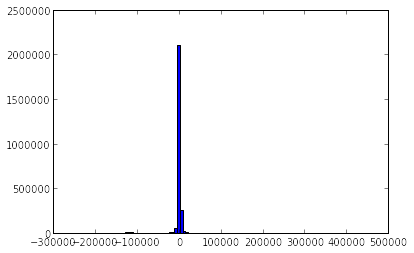

In [362]:
import datetime
print (datetime.datetime.utcfromtimestamp(start))

print (datetime.datetime.utcfromtimestamp(end))
print(datetime.datetime.utcfromtimestamp(1239079470.02500))
a, b, c = plt.hist(data, 100)

print(np.percentile(data, 15))
print(np.percentile(data, 85))
# print(c)

# Processing data

In this part, we process data extracted above.
Firstly, we set the sample rate as 10, which means that the time interval of reading every two successive data is 0.1s and it is downsampled to a quarter of original sample rate. Then we relate the amplitude that we read to 'density' value which is the key property in heatmap method we used later in our visualization. Also, we combine the density with latitude and longitude of station where the data we get and generate a 3-element tuple. So everytime we read data, we will get 450 tuples(because there are 450 stations in the US). These 450 tuples make up a 'frame' in our visualization. In addition, we divide these 450 tuples into 3 groups. The first group consists of all tuples that their density represents the positive amplitude, the second group consists of all tuples that their density represents the negtive amplitude and the last group consists of all tuples that their density represents that the station didn't receive seismic data.

In [365]:
interval = 0.1
t = start + 0
frame = []
while (t <= end):
    pos = []
    neg = []
    zero = []
    for wdata in wdata_list:
        if float(wdata['start_time']) <= t and float(wdata['end_time']) >= t:
            if wdata['data'][wdata['index']] < -1308.0:
                neg.append([wdata['lat'], wdata['lon'], 2500])
            elif wdata['data'][wdata['index']] > 1955.0:
                pos.append([wdata['lat'], wdata['lon'], 2500])
            else:
                n = wdata['data'][wdata['index']]
                if n < 0:
                    neg.append([wdata['lat'], wdata['lon'], 300 - n * 2200 / 1648])  
                elif 0 < n and n < 340:
                    neg.append([wdata['lat'], wdata['lon'], 300 + n * 2200 / 1648])  
                elif n > 340:
                    pos.append([wdata['lat'], wdata['lon'], 300 + n * 2200 / 1615])   
                else:
                    #print("bingo")
                    zero.append([wdata['lat'], wdata['lon'], 1200])
               
            i = wdata_list.index(wdata)
            wdata_list[i]['index'] += 4
        else:
            zero.append([wdata['lat'], wdata['lon'], 1200])
    
    frame.append([pos, neg, zero]) 
    t = t + interval

# Outputting data

In this part, we wrote the tuples generated above to javascript file. Because the data was so 'big' that if we write them to only one file, it cost so much time to load the javescript file and may cause web crash, we wrote the data to 4 seperate file. We stored them in four array variables in javascript file. And all we need to do in web page was to oad these four variables and read them element by element.

In [366]:
f = open("seismic_3groups_1.js", "w")
f.write("var pos1 =[")
for n in range(len(frame)/4):
    fr = frame[n]
    f.write("[")
    f.write("[")
    if len(fr[0]) > 0:
        for j in range( len(fr[0]) ):
            f.write("[" + fr[0][j][0] + "," + fr[0][j][1] + "," + str(fr[0][j][2]) + "]")
            if j != len(fr[0]) - 1:
                f.write(",")
    f.write("],[")
    if len(fr[1]) > 0:
        for j in range(len (fr[1]) ):
            f.write("[" + fr[1][j][0] + "," + fr[1][j][1] + "," + str(fr[1][j][2]) + "]")
            if j != len(fr[1]) - 1:
                f.write(",")   
    f.write("],[")
    if len(fr[2]) > 0:
        for j in range(len (fr[2]) ):
            f.write("[" + fr[2][j][0] + "," + fr[2][j][1] + "," + str(fr[2][j][2]) + "]")
            if j != len(fr[2]) - 1:
                f.write(",")  
    f.write("]]")
    if n != len(frame)/4 - 1:
        f.write(",")
    f.write("\n")
f.write("];")
f.close()

f = open("seismic_3groups_2.js", "w")
f.write("var pos2 =[")
for n in range(len(frame)/4, len(frame)/2):
    fr = frame[n]
    f.write("[")
    f.write("[")
    if len(fr[0]) > 0:
        for j in range( len(fr[0]) ):
            f.write("[" + fr[0][j][0] + "," + fr[0][j][1] + "," + str(fr[0][j][2]) + "]")
            if j != len(fr[0]) - 1:
                f.write(",")
    f.write("],[")
    if len(fr[1]) > 0:
        for j in range(len (fr[1]) ):
            f.write("[" + fr[1][j][0] + "," + fr[1][j][1] + "," + str(fr[1][j][2]) + "]")
            if j != len(fr[1]) - 1:
                f.write(",")   
    f.write("],[")
    if len(fr[2]) > 0:
        for j in range(len (fr[2]) ):
            f.write("[" + fr[2][j][0] + "," + fr[2][j][1] + "," + str(fr[2][j][2]) + "]")
            if j != len(fr[2]) - 1:
                f.write(",")  
    f.write("]]")
    if n != len(frame)/2 - 1:
        f.write(",")
    f.write("\n")
f.write("];")
f.close()

f = open("seismic_3groups_3.js", "w")
f.write("var pos3 =[")
for n in range(len(frame)/2, len(frame)/4 * 3):
    fr = frame[n]
    f.write("[")
    f.write("[")
    if len(fr[0]) > 0:
        for j in range( len(fr[0]) ):
            f.write("[" + fr[0][j][0] + "," + fr[0][j][1] + "," + str(fr[0][j][2]) + "]")
            if j != len(fr[0]) - 1:
                f.write(",")
    f.write("],[")
    if len(fr[1]) > 0:
        for j in range(len (fr[1]) ):
            f.write("[" + fr[1][j][0] + "," + fr[1][j][1] + "," + str(fr[1][j][2]) + "]")
            if j != len(fr[1]) - 1:
                f.write(",")   
    f.write("],[")
    if len(fr[2]) > 0:
        for j in range(len (fr[2]) ):
            f.write("[" + fr[2][j][0] + "," + fr[2][j][1] + "," + str(fr[2][j][2]) + "]")
            if j != len(fr[2]) - 1:
                f.write(",")  
    f.write("]]")
    if n != len(frame)/4 * 3 - 1:
        f.write(",")
    f.write("\n")
f.write("];")
f.close()

f = open("seismic_3groups_4.js", "w")
f.write("var pos4 =[")
for n in range(len(frame)/4 * 3, len(frame)):
    fr = frame[n]
    f.write("[")
    f.write("[")
    if len(fr[0]) > 0:
        for j in range( len(fr[0]) ):
            f.write("[" + fr[0][j][0] + "," + fr[0][j][1] + "," + str(fr[0][j][2]) + "]")
            if j != len(fr[0]) - 1:
                f.write(",")
    f.write("],[")
    if len(fr[1]) > 0:
        for j in range(len (fr[1]) ):
            f.write("[" + fr[1][j][0] + "," + fr[1][j][1] + "," + str(fr[1][j][2]) + "]")
            if j != len(fr[1]) - 1:
                f.write(",")   
    f.write("],[")
    if len(fr[2]) > 0:
        for j in range(len (fr[2]) ):
            f.write("[" + fr[2][j][0] + "," + fr[2][j][1] + "," + str(fr[2][j][2]) + "]")
            if j != len(fr[2]) - 1:
                f.write(",")  
    f.write("]]")
    if n != len(frame) - 1:
        f.write(",")
    f.write("\n")
f.write("];")
f.close()


# Why heat map?
After we finished the data part, now it came to the web page. In the web page, we selected heat map as our visualization tool. The reason why we did this was that the heat map provided some very good properties like radius, blur and gradient. Especially gradient, with the density, we can map the amplitude of the seismic wave to density easily and show the degree of how much the ground moves up and down by showing the gradient of that dot. Also, because heat map can have multiple heat layers, we can utilize this property to show different types of ground motion. We let the red to represent the positive amplitude, the blue the negative, and the grey the zero. In this way, we have a very clear contrast on the heat map.

# How to animate?
Javascript provided several ways to animate. What we selected was a function called SetInterval. We added one frame of data to the heat map, let it show a interval of time (Modifiable, we used this to adjust the animation speed in our project). Then we cleared the layer and added the next frame of data to the heat map.

# Interactive functionalities
The beauty of web page is that we can interact with the web page. In our project, we also achieve that goal. Even through we only provides some very simple functionalities, you can change the color of stations to show the positive or negative amplitudes. You can also change the animation speed of GMV.

# Reference:

[1]What Is Seismology and What Are Seismic Waves http://www.geo.mtu.edu/UPSeis/waves.html

[2]USArray GMV http://ds.iris.edu/ds/products/usarraygmv/

[3]Obspy https://github.com/obspy/obspy/wiki

[4]Filter https://en.wikipedia.org/wiki/Filter_(signal_processing)

[5]Decimation https://en.wikipedia.org/wiki/Decimation_(signal_processing)

[6]Pymongo https://api.mongodb.org/python/current/